## Gradient boosting from scratch

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
from sklearn.tree import DecisionTreeRegressor

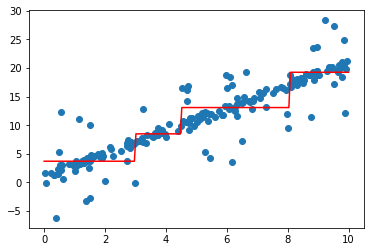

In [3]:
# toy example
m = 200
x = 10*np.random.rand(m,1)
y = 2*x+1 + 0.5*np.random.randn(m,1) # n = normal distribution
# add outlier
y[::5] += 20*(0.5 - np.random.rand(m//5,1))
y = y.flatten() # y as a vector
# regression tree
reg_tree = DecisionTreeRegressor(max_depth=2)
reg_tree.fit(x,y)
# plot the regression tree
m_plot = 200
x_plot = np.linspace(0,10,m_plot).reshape(m_plot,1)
y_plot = reg_tree.predict(x_plot)
plt.plot(x_plot,y_plot,color='red')
plt.scatter(x,y)

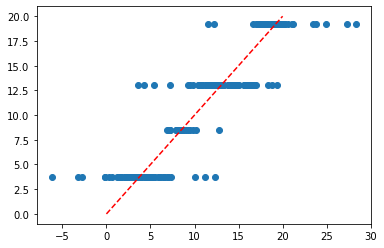

In [4]:
y_pred = reg_tree.predict(x)
plt.scatter(y,y_pred)
plt.plot([0,20],[0,20],'r--')

In [5]:
y_pred.shape

(200,)

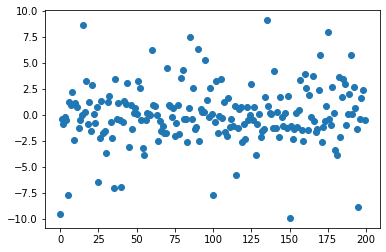

In [6]:
# residuals (errors)
y2 = y-y_pred
plt.plot(y2,'o')

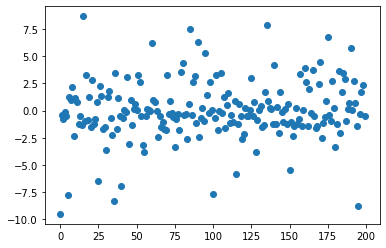

In [7]:
reg_tree2 = DecisionTreeRegressor(max_depth=2)
reg_tree2.fit(x,y2)
y2_pred = reg_tree2.predict(x)
# compute new residuals
y3 = y2-y2_pred
plt.plot(y3,'o')

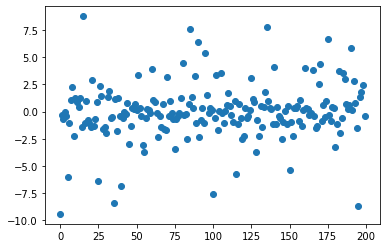

In [8]:
reg_tree3 = DecisionTreeRegressor(max_depth=2)
reg_tree3.fit(x,y3)
y3_pred = reg_tree3.predict(x)
# compute new residuals
y4 = y3-y3_pred
plt.plot(y4,'o')

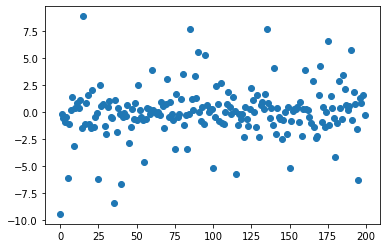

In [9]:
reg_tree4 = DecisionTreeRegressor(max_depth=2)
reg_tree4.fit(x,y4)
y4_pred = reg_tree4.predict(x)
# compute new residuals
y5 = y4-y4_pred
plt.plot(y5,'o')

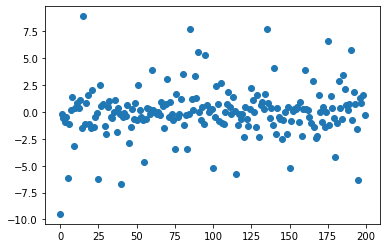

In [10]:
reg_tree5 = DecisionTreeRegressor(max_depth=2)
reg_tree5.fit(x,y5)
y5_pred = reg_tree5.predict(x)
# compute new residuals
y6 = y5-y5_pred
plt.plot(y6,'o')

In [11]:
# prediction
y_pred = y_pred + y2_pred + y3_pred + y4_pred +y5_pred

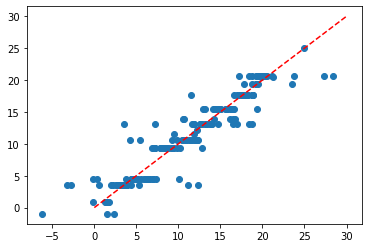

In [12]:
plt.scatter(y,y_pred)
plt.plot([0,30],[0,30],'r--')

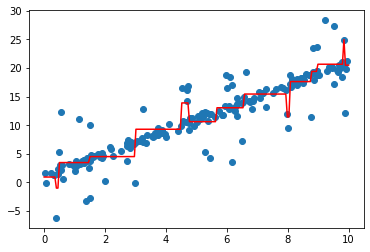

In [13]:
# plot gradient boosting model
y1_plot = reg_tree.predict(x_plot)
y2_plot = reg_tree2.predict(x_plot)
y3_plot = reg_tree3.predict(x_plot)
y4_plot = reg_tree4.predict(x_plot)
y5_plot = reg_tree5.predict(x_plot)
y_plot = y1_plot + y2_plot + y3_plot + y4_plot + y5_plot
plt.scatter(x,y)
plt.plot(x_plot,y_plot,color='red')

## building a gradient boosting model in scikit-learn 

In [14]:
from sklearn.ensemble import GradientBoostingRegressor

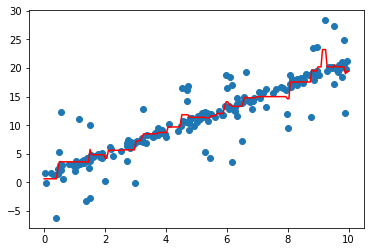

In [15]:
# as n_estimators goes up, learning_rate should go down
gb_reg = GradientBoostingRegressor(n_estimators=100,
                                   max_depth=2,
                                   learning_rate=0.05)
gb_reg.fit(x,y)
y_plot = gb_reg.predict(x_plot)
plt.scatter(x,y)
plt.plot(x_plot,y_plot,color='red')

## Fremont Bridge

In [16]:
# load  traffic, weather, and air quality index datasets
fremont = pd.read_csv('Fremont_Bridge_Bicycle_Counter.csv',index_col='Date',parse_dates=True).resample('d').sum()
weather = pd.read_csv('Seattle_weather.csv',index_col='DATE',parse_dates=True)
aqi = pd.read_csv('Seattle_air_quality_index.csv',index_col='Date',parse_dates=True)

# add day of the week/month/year/covid columns
fremont['day_of_week'] = fremont.index.dayofweek
fremont['month'] = fremont.index.month
fremont['year'] = fremont.index.year
fremont['covid'] = 0
fremont.loc['03-01-2020':,'covid'] = 1

# add holidays column
from pandas.tseries.holiday import USFederalHolidayCalendar
calendar = USFederalHolidayCalendar()
holidays = calendar.holidays('01-01-2013','09-30-2022')
fremont['holidays'] = pd.Series(1,index=holidays,name='holidays')
fremont.fillna(0,inplace=True)

# add hours of daylight column
def get_hoursdaylight(date):
    axis = np.radians(23.44) # tilt of Earth's axis
    latitude = np.radians(47.61) # Seattle's latidude 
    days = (date-pd.to_datetime('2000-12-31')).days
    m = (1 - np.tan(latitude)*np.tan(axis*np.cos(days*2*np.pi/365.25)))
    return 24*np.degrees(np.arccos(1-m))/180
fremont['hours_daylight'] = fremont.index.map(get_hoursdaylight)

# fix TAVG column
weather.TAVG.fillna(0.5*(weather.TMAX+weather.TMIN),inplace=True)

# join weather and traffic datasets
fremont = fremont.join(weather[['PRCP','TAVG','SNOW','AWND']]).loc['2013-01-01':]

# add air quality index
fremont['aqi'] = aqi

# fix aqi missing values
fremont.fillna(method='ffill',inplace=True)

In [17]:
# 2013-2020 (training data)
fremont2013_2020 = fremont[fremont.index.year<2021].copy()
# 2021-2022 (test data) 
fremont2021_2022 = fremont[fremont.index.year>=2021].copy()

# target vector / feature matrix
y2013_2020 = fremont2013_2020['Fremont Bridge Total']
X2013_2020 = fremont2013_2020[['day_of_week','covid','holidays','hours_daylight','PRCP','TAVG','SNOW','AWND','year','aqi']]

X2021_2022 = fremont2021_2022[['day_of_week','covid','holidays','hours_daylight','year','PRCP','TAVG','SNOW','AWND','aqi']]
y2021_2022 = fremont2021_2022['Fremont Bridge Total']

In [18]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV

In [19]:
# regression pipeline
num_features = ['hours_daylight','PRCP','TAVG','SNOW','AWND','year','aqi']
cat_features = ['day_of_week','covid','holidays']

feature_processor = ColumnTransformer(transformers=[
    ('encoder',OneHotEncoder(handle_unknown='ignore'),cat_features),
],remainder='passthrough')

# regression pipeline
pipe = Pipeline(steps=[
    ('feature_processor',feature_processor),
    #('scaler', MinMaxScaler()),
    #('poly_features',PolynomialFeatures(degree=2)),
    ('regressor',GradientBoostingRegressor()) 
])

In [20]:
# grid search
param_dic = {'regressor__max_depth':[2,5,8], 
             'regressor__n_estimators':[10,50,100,200,500,1000],
             'regressor__learning_rate':[0.001,0.01,0.1,0.5,1]}
grid = GridSearchCV(pipe,
                    param_dic,
                    cv=10,
                    scoring='neg_mean_squared_error',
                    n_jobs=-1,
                    verbose=True)
grid.fit(X2013_2020,y2013_2020)

Fitting 10 folds for each of 75 candidates, totalling 750 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('feature_processor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('encoder',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['day_of_week',
                                                                          'covid',
                                                                          'holidays'])])),
                                       ('regressor',
                                        GradientBoostingRegressor())]),
             n_jobs=-1,
             param_grid={'regressor__learning_rate': [0.001, 0.01, 0.1, 0.5, 1],
                         'regressor__max_depth': [2, 5, 8],
                         'regressor__n_estimators': [10, 50, 100, 200, 500]},
             scoring='neg_mean_squared_error', verbose=True)

In [28]:
grid.best_params_

{'regressor__learning_rate': 0.1,
 'regressor__max_depth': 2,
 'regressor__n_estimators': 500}

In [21]:
best_pipe = grid.best_estimator_

In [25]:
fremont2013_2020['prediction'] = best_pipe.predict(X2013_2020)
fremont2021_2022['prediction'] = best_pipe.predict(X2021_2022)

<AxesSubplot:xlabel='Date'>

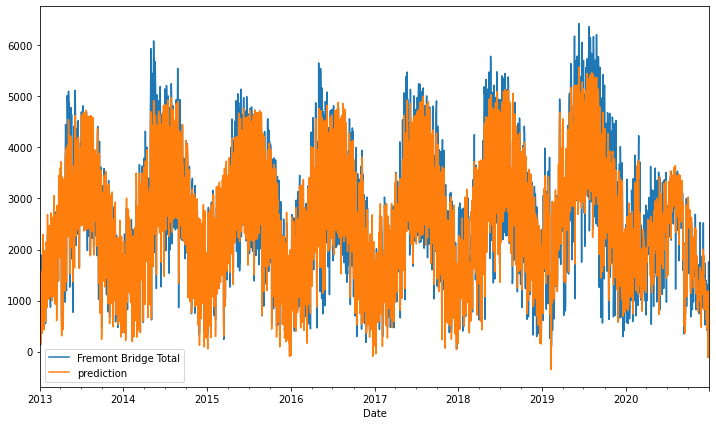

In [24]:
fremont2013_2020[['Fremont Bridge Total', 'prediction']].plot(figsize=(12,7))

<AxesSubplot:xlabel='Date'>

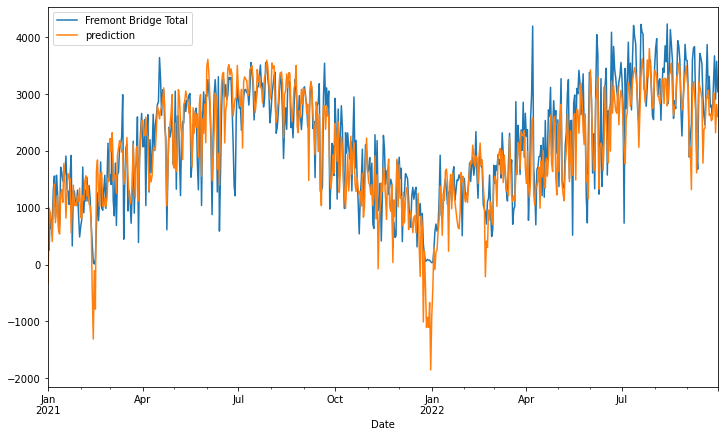

In [26]:
fremont2021_2022[['Fremont Bridge Total', 'prediction']].plot(figsize=(12,7))

In [29]:
from sklearn.metrics import mean_squared_error

In [31]:
np.sqrt(mean_squared_error(y2013_2020,fremont2013_2020['prediction']))

400.07148437707525

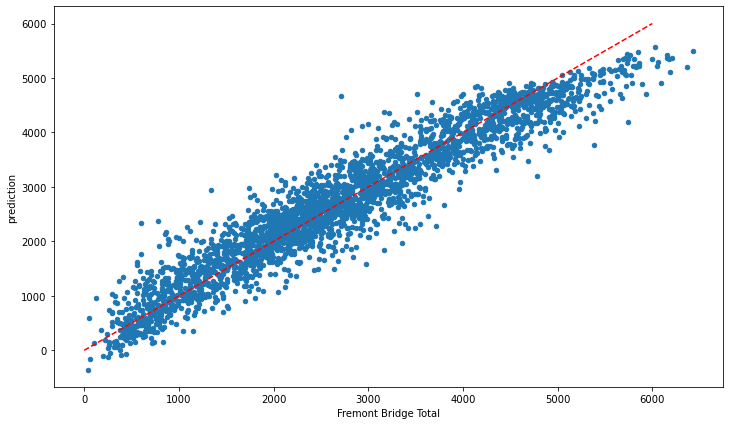

In [33]:
fremont2013_2020.plot.scatter(x='Fremont Bridge Total',
                              y='prediction', 
                              figsize=(12,7))
plt.plot([0,6000],[0,6000],'r--')